In [1]:
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.dpi'] = 300

%matplotlib inline

Loading data
===

In [2]:
df = pd.read_csv("TitanRUR/2017_filtered.csv")

df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

In [3]:
df.head()

,Unnamed: 0,user_id,start_time,end_time,stime,utime,alps_exit,alps_nppn,alps_width,alps_resid,...,node_count,max_rss,rchar,wchar,gpu_mode,gpu_pids,gpu_secs,gpu_maxsecs,gpu_maxmem,gpu_summem
0,0,User1423,2017-02-22 17:32:56.408987,2017-02-22 19:19:57.105969,629276000.0,6.151264e+09,0,0.0,1.0,787369,...,1,208640.0,6.942068e+09,6.957689e+09,exclusive_process,1.0,5196.0,5196.0,204996608.0,204996608.0
1,1,User1423,2017-02-22 17:32:56.417489,2017-02-22 19:20:16.481059,614768000.0,6.183444e+09,0,0.0,1.0,787369,...,1,208640.0,6.952067e+09,6.967698e+09,exclusive_process,1.0,5212.0,5212.0,204996608.0,204996608.0
2,2,User1423,2017-02-22 17:32:56.425189,2017-02-22 19:20:20.793754,639016000.0,6.184016e+09,0,0.0,1.0,787369,...,1,208636.0,6.948583e+09,6.964200e+09,exclusive_process,1.0,5216.0,5216.0,204996608.0,204996608.0
3,3,User1423,2017-02-22 17:32:56.524607,2017-02-22 19:20:22.519211,636804000.0,6.217792e+09,0,0.0,1.0,787369,...,1,208636.0,6.954982e+09,6.970612e+09,exclusive_process,1.0,5281.0,5281.0,204996608.0,204996608.0
4,4,User1423,2017-02-22 17:32:56.476290,2017-02-22 19:20:37.270860,649464000.0,6.154936e+09,0,0.0,1.0,787369,...,1,208636.0,6.948463e+09,6.964095e+09,exclusive_process,1.0,5229.0,5229.0,204996608.0,204996608.0


In [4]:
df.columns

Index(['Unnamed: 0', 'user_id', 'start_time', 'end_time', 'stime', 'utime',
       'alps_exit', 'alps_nppn', 'alps_width', 'alps_resid', 'aprun_id',
       'command', 'node_count', 'max_rss', 'rchar', 'wchar', 'gpu_mode',
       'gpu_pids', 'gpu_secs', 'gpu_maxsecs', 'gpu_maxmem', 'gpu_summem'],
      dtype='object')

In [5]:
df.shape

(406222, 22)

In [6]:
df['alps_exit'].value_counts()

0    406222
Name: alps_exit, dtype: int64


Observations on 2019 dataset
===

* 2,30,559 jobs in 2019 which have gpu_secs > 0
* Out of these, 3758 jobs have maxmem > 0 and summem > 0

1. `alps_nppn` is number of processes per node
2. `alps_width` is nppn\*number_of_nodes
3. `gpu_pids` is either 1 or 2
4. `gpu_maxmem` and `gpu_summem` is mostly zero
5. `gpu_maxmem` is max GPU memory used by any node at any time
6. `gpu_secs` is always more than `gpu_maxsecs`, guessing `gpu_secs` is sum of gpu seconds used across all nodes
5. Only 3758 jobs in 2019, which have gpu_maxmem > 0. All of these jobs also have gpu_summem > 0.



Tasks
---

1. Calculate job size in core-hours, like it is done in paper (via `number_of_nodes`, and `stime`, `utime`)

Questions about dataset
---

What is
* aprun_id
* alps_resid


* What is the difference between `gpu_secs` and `gpu_maxsecs` fields?  
  gpu max secs is max gpu seconds used across all nodes, and gpu_secs is the total seconds summed across the nodes.
  
<hr/>
  
* What exactly is `gpu_summem`? Defined in dataset as "Total GPU memory used by all the nodes.", does that mean sum of maximum gpu memories used by the job at some point?
* There are jobs in the dataset, which have `gpu_secs > 0` but `gpu_maxmem = 0` i.e many jobs use the GPU for computation, but do not use any memory on the GPU??

**Interesting Observation**: Only 3758 jobs which have gpu memory usage as positive, rest have GPU usage in seconds, but gpu memory used is displayed as zero

Data Analysis
===

Text(0, 0.5, 'Number of jobs')

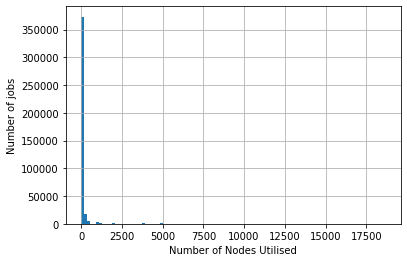

In [6]:
df['node_count'].hist(bins=100)
plt.xlabel("Number of Nodes Utilised")
plt.ylabel("Number of jobs")

In [32]:
df['node_count'].describe()

count    405407.000000
mean        145.654683
std         909.896526
min           1.000000
25%           1.000000
50%           8.000000
75%          50.000000
max       18685.000000
Name: node_count, dtype: float64

In [7]:
job_times = (df['end_time'] - df['start_time'])/np.timedelta64(1, 's')

df['gpu_pct'] = df['gpu_secs']/(job_times*df['node_count'])

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(how="all", inplace=True)

df['gpu_pct']

0         0.809258
1         0.809309
2         0.809389
3         0.819268
4         0.809343
            ...   
406217    0.354801
406218    0.307029
406219    0.089973
406220    0.319258
406221    0.363824
Name: gpu_pct, Length: 406222, dtype: float64

**Observation**: Notice that there are jobs which have significantly more gpu_secs than the wall time of the job.  

How is this possible?

TODO: Remove outliers, i.e greater than 100% utilisation

In [8]:
df['gpu_pct'].describe()

count    4.062190e+05
mean     5.171585e-01
std      2.956519e-01
min      5.125621e-07
25%      3.483860e-01
50%      4.831658e-01
75%      7.417391e-01
max      1.360827e+01
Name: gpu_pct, dtype: float64

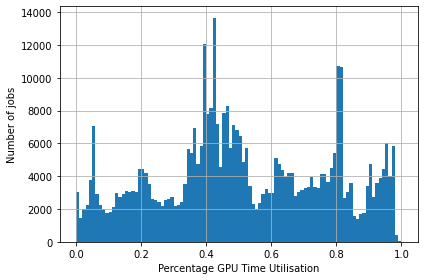

In [9]:
lel = df['gpu_pct'][df['gpu_pct'] <= 1]
lel.hist(bins=100)
plt.xlabel("Percentage GPU Time Utilisation")
plt.ylabel("Number of jobs")

plt.savefig("GPU_Util_hist.svg")
plt.tight_layout()

In [34]:
df['gpu_pct'].describe()

count    4.054070e+05
mean     5.126876e-01
std      2.603057e-01
min      5.125621e-07
25%      3.480950e-01
50%      4.820051e-01
75%      7.394423e-01
max      9.997966e-01
Name: gpu_pct, dtype: float64

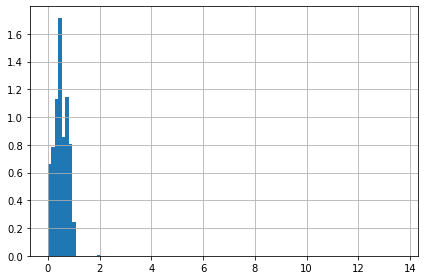

In [10]:
df['gpu_pct'].hist(bins=100, density=1)
plt.tight_layout()

In [11]:
df.iloc[df['gpu_pct'].argmax()]

Unnamed: 0                                       1023440
user_id                                         User1670
start_time                    2017-06-18 23:47:44.692170
end_time                      2017-06-19 02:36:47.826063
stime                                     261161204000.0
utime                                   20463120152000.0
alps_exit                                              0
alps_nppn                                            0.0
alps_width                                        2048.0
alps_resid                                        985411
aprun_id                                        14634709
command        /lustre/atlas/User1670/Area32-211/omnibus
node_count                                           128
max_rss                                         909232.0
rchar                                      11033354372.0
wchar                                       6445613169.0
gpu_mode                                         default
gpu_pids                       

In [14]:
df.iloc[403280]

Unnamed: 0                                               2791475
user_id                                                 User1028
start_time                            2017-03-29 18:49:28.274904
end_time                              2017-03-29 23:13:55.402118
stime                                           24704583296000.0
utime                                          227408554128000.0
alps_exit                                                      0
alps_nppn                                                    1.0
alps_width                                               15000.0
alps_resid                                                855051
aprun_id                                                14124541
command        /lustre/atlas/User1028/Area15-209/MENNDL_Maste...
node_count                                                 15000
max_rss                                                1621764.0
rchar                                              46160836099.0
wchar                    

1. Detect keywords in `command` field: eg, NN, DL, tensorflow, etc

2. Run unsupervised clustering, check cluster types

keywords like: ML, CNN, RNN, DNN, etc

In [15]:
df = df[df['gpu_pct'] <= 1]
job_times = (df['end_time'] - df['start_time'])/np.timedelta64(1, 's')

Normalise rchar and wchar, by job times to obtain throughput



Text(0, 0.5, 'Bytes Read (per sec)')

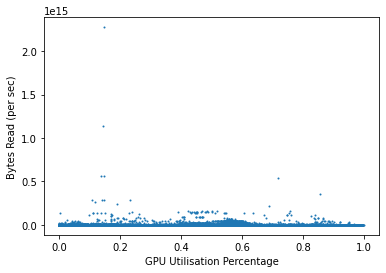

In [16]:
%matplotlib inline

plt.scatter(df['gpu_pct'], df['rchar'], s=1)
plt.xlabel("GPU Utilisation Percentage")
plt.ylabel("Bytes Read (per sec)")

In [17]:
df['rchar'].describe()

count    4.054070e+05
mean     1.515581e+11
std      4.948774e+12
min      0.000000e+00
25%      2.014075e+08
50%      2.890116e+09
75%      2.329751e+10
max      2.276067e+15
Name: rchar, dtype: float64

In [18]:
(df['rchar'] > df['rchar'].mean()).sum()

28815

In [19]:
df['rchar'].shape

(405407,)

In [20]:
df['gpu_pct'].describe()

count    4.054070e+05
mean     5.126876e-01
std      2.603057e-01
min      5.125621e-07
25%      3.480950e-01
50%      4.820051e-01
75%      7.394423e-01
max      9.997966e-01
Name: gpu_pct, dtype: float64

In [21]:
((df['rchar'] > df['rchar'].mean()) & (df['gpu_pct'] > df['gpu_pct'].mean())).sum()

7345

In [22]:
df['times'] = job_times

In [23]:
df['times'].describe()

count    405407.000000
mean       3107.298334
std        5252.295017
min           1.669783
25%         211.742263
50%        2281.991867
75%        4253.099656
max       86432.667723
Name: times, dtype: float64

In [24]:
((df['rchar'] > df['rchar'].mean()) & (df['gpu_pct'] > df['gpu_pct'].mean()) & (df['times'] > df['times'].mean())).sum()

6162

In [25]:
df['node_count'].describe()

count    405407.000000
mean        145.654683
std         909.896526
min           1.000000
25%           1.000000
50%           8.000000
75%          50.000000
max       18685.000000
Name: node_count, dtype: float64

Are the keyword jobs also in these 6k jobs?

TODO: Check the keywords, if in the above 6k jobs to validate the hypothesis

Check about write and read/write ratios as well, conclusion to drive the hypothesis

Could find: long running jobs with high GPU utilisation and IO usage

<AxesSubplot:>

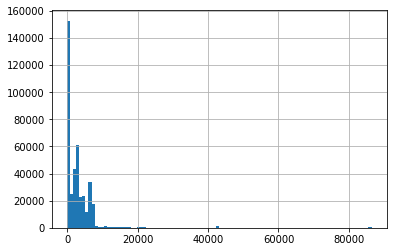

In [26]:
df['times'].hist(bins=100)

Text(0, 0.5, 'Bytes Written (per sec)')

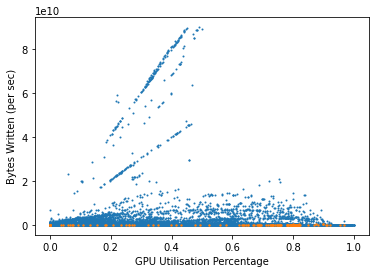

In [27]:
plt.scatter(df['gpu_pct'], df['wchar']/job_times, s=1)

menndl = df[df['command'].str.contains("NN")]
menndl_times = (menndl['end_time'] - menndl['start_time'])/np.timedelta64(1, 's')

plt.scatter(menndl['gpu_pct'], menndl['wchar']/menndl_times, s=2)

plt.xlabel("GPU Utilisation Percentage")
plt.ylabel("Bytes Written (per sec)")

Text(0, 0.5, 'Bytes Written (per sec)')

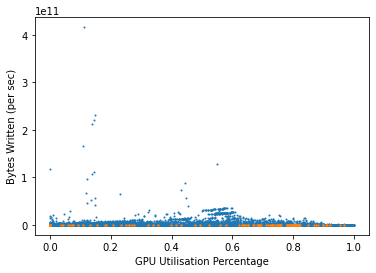

In [28]:
plt.scatter(df['gpu_pct'], df['rchar']/job_times, s=1)

menndl = df[df['command'].str.contains("NN")]
menndl_times = (menndl['end_time'] - menndl['start_time'])/np.timedelta64(1, 's')

plt.scatter(menndl['gpu_pct'], menndl['rchar']/menndl_times, s=2)

plt.xlabel("GPU Utilisation Percentage")
plt.ylabel("Bytes Written (per sec)")

Text(0, 0.5, 'Job Wall Time (seconds)')

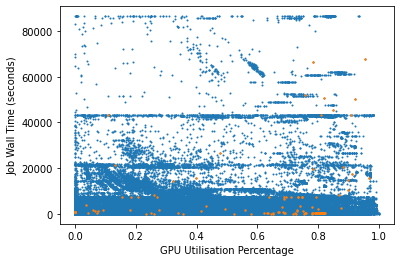

In [29]:
plt.scatter(df['gpu_pct'], job_times, s=1)
plt.scatter(menndl['gpu_pct'], menndl_times, s=2)


plt.xlabel("GPU Utilisation Percentage")
plt.ylabel("Job Wall Time (seconds)")

Text(0, 0.5, 'Nodes Used')

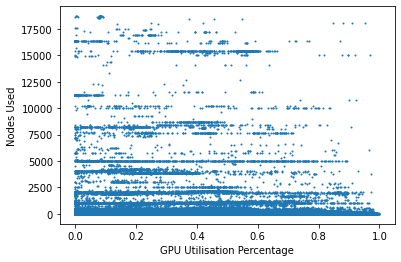

In [30]:
plt.scatter(df['gpu_pct'], df['node_count'], s=1)
plt.xlabel("GPU Utilisation Percentage")
plt.ylabel("Nodes Used")

Text(0, 0.5, 'GPU Maximum Memory Used')

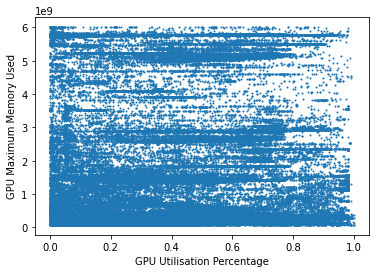

In [31]:
plt.scatter(df['gpu_pct'], df['gpu_maxmem'], s=1)
plt.xlabel("GPU Utilisation Percentage")
plt.ylabel("GPU Maximum Memory Used")

Text Analysis for keywords
===

In [18]:
df[df['command'].str.contains("NN")]['command']

19906              /lustre/atlas/User1028/Area15-177/MENNDL
19922              /lustre/atlas/User1028/Area15-177/MENNDL
20160              /lustre/atlas/User1028/Area15-177/MENNDL
28029              /lustre/atlas/User1028/Area15-177/MENNDL
28103              /lustre/atlas/User1028/Area15-177/MENNDL
                                ...                        
402318    /lustre/atlas/User1028/Area15-209/MENNDL_Maste...
402325    /lustre/atlas/User1028/Area15-209/MENNDL_Maste...
402328    /lustre/atlas/User1028/Area15-209/MENNDL_Maste...
403040    /lustre/atlas/User1028/Area15-209/MENNDL_Maste...
403280    /lustre/atlas/User1028/Area15-209/MENNDL_Maste...
Name: command, Length: 155, dtype: object

In [56]:
df[df['command'].str.contains("tensor")]['command']

63629     ./ptensor
63632     ./ptensor
63633     ./ptensor
116049    ./ptensor
116052    ./ptensor
            ...    
319892    ./ptensor
319893    ./ptensor
321111    ./ptensor
321124    ./ptensor
321341    ./ptensor
Name: command, Length: 215, dtype: object

In [35]:
df[df['command'].str.contains("DL")]['command']

19906              /lustre/atlas/User1028/Area15-177/MENNDL
19922              /lustre/atlas/User1028/Area15-177/MENNDL
20160              /lustre/atlas/User1028/Area15-177/MENNDL
28029              /lustre/atlas/User1028/Area15-177/MENNDL
28103              /lustre/atlas/User1028/Area15-177/MENNDL
                                ...                        
402318    /lustre/atlas/User1028/Area15-209/MENNDL_Maste...
402325    /lustre/atlas/User1028/Area15-209/MENNDL_Maste...
402328    /lustre/atlas/User1028/Area15-209/MENNDL_Maste...
403040    /lustre/atlas/User1028/Area15-209/MENNDL_Maste...
403280    /lustre/atlas/User1028/Area15-209/MENNDL_Maste...
Name: command, Length: 152, dtype: object

In [32]:
df[df['command'].str.contains("Area15")]['command'][406193]

'/lustre/atlas/User1468/Area15-118/sus-gpu-incite-dev'

In [28]:
((df['rchar'] > df['rchar'].mean()) & \
 (df['gpu_pct'] > df['gpu_pct'].mean()) & \
 (df['times'] > df['times'].mean()) & \
 (df['command'].str.contains("MENNDL"))
)\
.sum()

1

In [31]:
((df['rchar'] > df['rchar'].mean()) & \
 (df['gpu_pct'] > df['gpu_pct'].mean()) & \
 (df['times'] > df['times'].mean()) & \
 (df['command'].str.contains("ptensor"))
)\
.sum()

0

Keywords found in dataset
===

1. Caffe: Deep learning framework (6112)
2. LeNet: Original LeNet model (345)
3. MENNDL: Hyperparameter tuning along with model training (366)
4. Cifar10: Dataset for Computer Vision models (10)
5. AlexNet: Modified 2012 AlexNet model (3)
6. ImageNet: training scripts related to ImageNet challenge (198)

Around 7k total jobs